- Find or model time seies.
- Build smoothed time series.
- Build correct trend for time series.
- Define trend determination coefficent.
- Predict (and show on plot) 5 predict values.
- Estimate prediction with MAPE metric.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.style.use('seaborn')

# Importing data

In [2]:
data = pd.read_csv('../data/energy_consumption.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.sort_values(by=['Datetime'], inplace=True)
display(data)

,Datetime,PJME_MW
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0
...,...,...
140250,2018-08-02 20:00:00,44057.0
140251,2018-08-02 21:00:00,43256.0
140252,2018-08-02 22:00:00,41552.0
140253,2018-08-02 23:00:00,38500.0


There is too much of data so we will use only data for 1 month.

In [3]:
# Taking first 24 * 8 = 192 hours.
start_from_day = 411
data_days = data.iloc[start_from_day*24 : start_from_day*24 + 192]

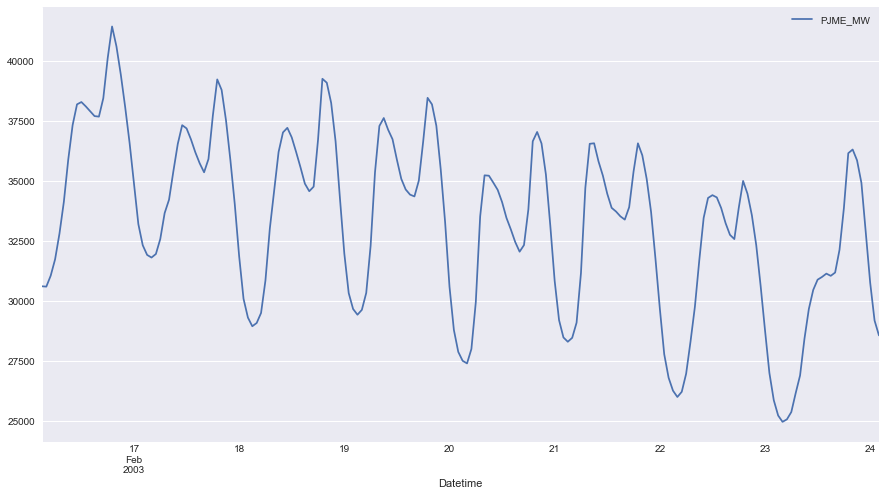

In [4]:
# Building plot.
data_days.plot(x='Datetime', y='PJME_MW', figsize=(15, 8))
plt.show()

In [5]:
x = np.array(data_days['Datetime'])
y = np.array(data_days['PJME_MW'])

# Smoothing time series 

In [6]:
def SMA(y, k):
    """Simple moving average smoothing.
    
    Args:
        y (list): Values to smooth.
        k (int): number of neighbours to one side.        
    """
    
    coef = (1 / (2 * k + 1))
    
    y_center = y[k:-k+1]
    y_smoothed = y[:k]
    
    for i in range(k, len(y)-k+1):
        sum = 0
        for j in range(-k, k) :
            sum += y[i + j]
        y_smoothed.append(coef*sum)
                            
    y_smoothed += y[-k + 1:]
    
    return y_smoothed

In [7]:
# Initializing DataFrame with smoothed values.
data_month_smoothed = pd.DataFrame()
data_month_smoothed['Datetime'] = x
data_month_smoothed['PJME_MW'] = SMA(list(y), 5)

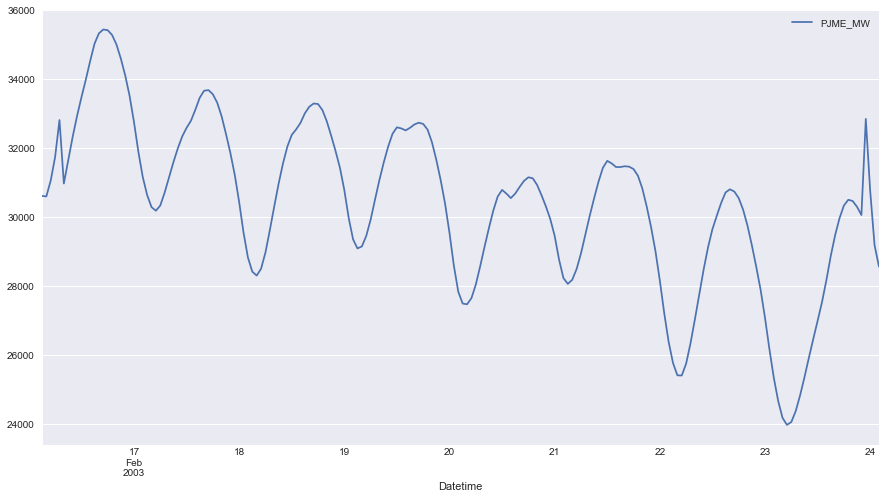

In [8]:
# Building plot.
data_month_smoothed.plot(x='Datetime', y='PJME_MW', figsize=(15, 8))
plt.show()

In [9]:
x_smoothed = np.array(data_month_smoothed['Datetime'])
y_smoothed = np.array(data_month_smoothed['PJME_MW'])

# Building trend line 

In [10]:
# Splitting data to train/test samples.
split_mark = 0.7

split_point = round(len(x_smoothed) * split_mark)

x_train = x_smoothed[:split_point].reshape(-1,1).astype('float')
y_train = y_smoothed[:split_point].reshape(-1,1).astype('float')

x_test = x_smoothed[split_point:].reshape(-1,1).astype('float')
y_test = y_smoothed[split_point:].reshape(-1,1).astype('float')

In [11]:
# Create linear regression object.
regr = LinearRegression()

# Train the model using the training sets.
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# Making predictions on all data.
whole_data_predictions = regr.predict(x_smoothed.reshape(-1,1).astype('float'))

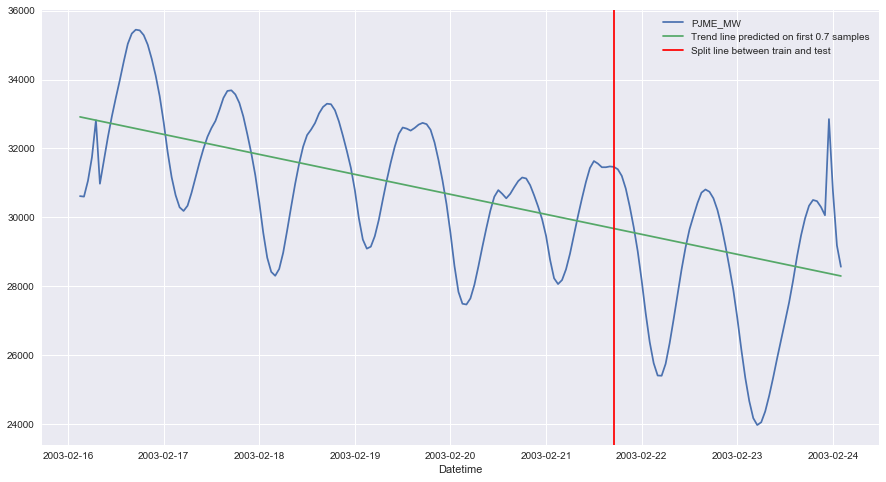

In [13]:
# Building plot.
plt.figure(figsize=(15, 8))

plt.plot(data_month_smoothed['Datetime'], data_month_smoothed['PJME_MW'], label='PJME_MW')
plt.plot(data_month_smoothed['Datetime'], whole_data_predictions.T[0], label = "Trend line predicted on first {} samples".format(split_mark))
plt.axvline(x=data_month_smoothed['Datetime'].iloc[split_point], c='r', label = "Split line between train and test")

plt.xlabel('Datetime')
plt.legend()

plt.show()

# Analyzing result 

In [14]:
def squared_error(y_true, y_pred):    
    return np.sum(np.square(y_true - y_pred))

def coefficient_of_determination(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    return 1 - squared_error(y_true, y_pred)/squared_error(y_true, y_true_mean)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
# Making predictions.
predictions = regr.predict(x_test)

In [16]:
# Printing results.
cd = coefficient_of_determination(y_test, predictions)
mae = mean_absolute_percentage_error(y_test, predictions)

print("Coefficient of determination: {:.2f}".format(cd))
print("Mean absolute percentage error: {:.2f}".format(mae))

Coefficient of determination: -0.11
Mean absolute percentage error: 7.41
